In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

## Background noise

In [2]:
from pathlib import Path
from birdclef import birdnet
from birdclef.utils import get_spark
from pyspark.sql import functions as F
import pickle
import tqdm
import time
import tensorflow as tf
from functools import partial
import librosa
from birdclef.data.utils import slice_seconds
import numpy as np

repo_path = Path("../data/models/birdnet-analyzer-pruned")
birdnet_model = birdnet.load_model_from_repo(repo_path)
embedding_func = birdnet.embedding_func(birdnet_model)


model_path = Path("../data/models/baseline/logistic_binary.pkl")
clf = pickle.loads(model_path.read_bytes())

# re-encode the classes properly for the inference script on logistic model
le_path = Path("../data/models/baseline/logistic_binary_label_encoder.pkl")
le = pickle.loads(le_path.read_bytes())
clf.classes_ = le.classes_

spark = get_spark()
spark

2023-06-06 21:40:24.156464: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-06 21:40:43.776718: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-06 21:40:43.776974: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-06-06 21:40:43.776989: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

23/06/06 21:41:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/06/06 21:41:56 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
def average_windows(prob):
    """Average a matrix of probabilities.

    We assume that these are a sliding window of probabilities: 1s sliding window of 3s context
    """
    # max might be better than the mean
    return prob.reshape(-1, 2, prob[0].size).max(axis=1)


def run_inference(path, embedding_func, clf, sr=48000):
    y, sr = librosa.load(path.as_posix(), sr=sr, mono=True)
    X = slice_seconds(y, sr, seconds=3, step=3)
    # drop every 4th/5th index, so we're not processing more than we need to
    # first pad the resulting slices by 2
    # X = np.pad(X, ((0, 2), (0, 0)))
    # # then reshape it
    # X = X.reshape(-1, 5, X.shape[-1])
    # # now drop the last 2 second of each 5 second frame
    # X = X[:, [0, 2], :].reshape(-1, X.shape[-1])
    # assert X.shape == (120 * 2, sr * 3), X.shape

    emb = embedding_func(X)[0]
    prob = clf.predict_proba(emb)
    # prob_prime = average_windows(prob)
    # assert prob_prime.shape == (120, len(clf.classes_)), prob_prime.shape
    rows = []
    for i, (probs_row, embs_row) in enumerate(zip(prob, emb)):
        ts = i * 3
        row = dict(
            row_id=f"{path.stem}_{ts}",
            emb=embs_row,
            **dict(zip(clf.classes_, np.around(probs_row, 6).tolist())),
        )
        rows.append(row)
    return rows


test_path = Path("../data/raw/background_audio/")
rows = []
timings = []
for path in tqdm.tqdm(test_path.glob("*.wav")):
    start = time.time()
    rows += run_inference(path, embedding_func, clf)
    timings.append(time.time() - start)

avg_time_sec = np.mean(timings)
est_time_min = avg_time_sec * 200 / 60
print(
    f"took {round(avg_time_sec,2)} seconds per loop, estimated {round(est_time_min,2)} minutes"
)

2034it [11:48,  2.87it/s]

took 0.35 seconds per loop, estimated 1.16 minutes


In [4]:
import pandas as pd

rows_df = pd.DataFrame(rows)
display(rows_df)

,row_id,emb,call,no_call
0,0c983624-94c9-488f-a30a-ff4607d91844_0,"[1.1818925, 0.6968763, 1.1667963, 1.0317761, 0...",0.601083,0.398917
1,0c983624-94c9-488f-a30a-ff4607d91844_3,"[1.1214463, 0.76188964, 0.7962134, 0.67655396,...",0.458803,0.541197
2,0c983624-94c9-488f-a30a-ff4607d91844_6,"[1.2807318, 0.84491104, 0.86374253, 0.8848675,...",0.664885,0.335115
3,0c983624-94c9-488f-a30a-ff4607d91844_9,"[1.2563802, 0.4798907, 0.6529888, 1.1251913, 0...",0.671808,0.328192
4,324c7e9e-5962-49e2-ae32-c695a024ac26_0,"[0.9624713, 0.6796997, 0.73333937, 0.6342775, ...",0.104459,0.895541
...,...,...,...,...
8131,2aad176a-4d4e-44d2-a878-2196db6286ea_9,"[0.733079, 0.58992493, 0.41016603, 0.8734186, ...",0.051229,0.948771
8132,2a8691c8-c0eb-43c0-a278-b89fd208ac89_0,"[0.7875113, 0.27573064, 1.3166841, 0.77909, 0....",0.109444,0.890556
8133,2a8691c8-c0eb-43c0-a278-b89fd208ac89_3,"[0.8198197, 0.60482556, 1.4028622, 0.67793566,...",0.155068,0.844932
8134,2a8691c8-c0eb-43c0-a278-b89fd208ac89_6,"[0.8320904, 0.59047955, 1.4423494, 0.5654103, ...",0.124127,0.875873


In [5]:
# Write out res to a parquet file, using 1 or 2 partitions.
# Use the processed/birdnet-2023 folder and make a new dataset under there.
spark_df = spark.createDataFrame(rows_df)
spark_df.repartition(2).write.mode("overwrite").parquet(
    "../data/processed/birdclef-2023/background_noise"
)

/home/mgustine/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


23/06/06 21:54:06 WARN TaskSetManager: Stage 0 contains a task of very large size (2670 KiB). The maximum recommended task size is 1000 KiB.


In [2]:
import numpy as np
import pandas as pd
from birdclef.utils import get_spark

spark = get_spark(cores=4, memory="10g")
df = spark.read.parquet("../data/processed/birdclef-2023/background_noise")
df.printSchema()

# Data for model training
rows_df = df.toPandas()
rows_df.head()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/06/07 12:51:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- row_id: string (nullable = true)
 |-- emb: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- call: double (nullable = true)
 |-- no_call: double (nullable = true)



,row_id,emb,call,no_call
0,04029e3d-f38d-4732-a4f3-ed7d9a5ecce0_9,"[0.4765618, 0.46414986, 0.3187426, 1.00798, 0....",0.058981,0.941019
1,3206a89e-62ea-47d1-ac6c-bbf4d89baba9_9,"[1.0740846, 0.567787, 0.44531855, 0.44690418, ...",0.188369,0.811631
2,2969c474-14ea-43d3-a785-74812a1012d1_9,"[0.7935006, 0.6650428, 0.4069828, 0.2370947, 0...",0.015613,0.984387
3,1f26ba64-6697-4273-a378-c890e6d20720_9,"[1.0788813, 0.6915334, 0.3761121, 0.38029405, ...",0.011214,0.988786
4,2c514c7d-cdf9-4fb1-a6f3-1099d93442c2_3,"[0.40857872, 0.8114722, 0.60223275, 0.67038375...",0.117450,0.882550


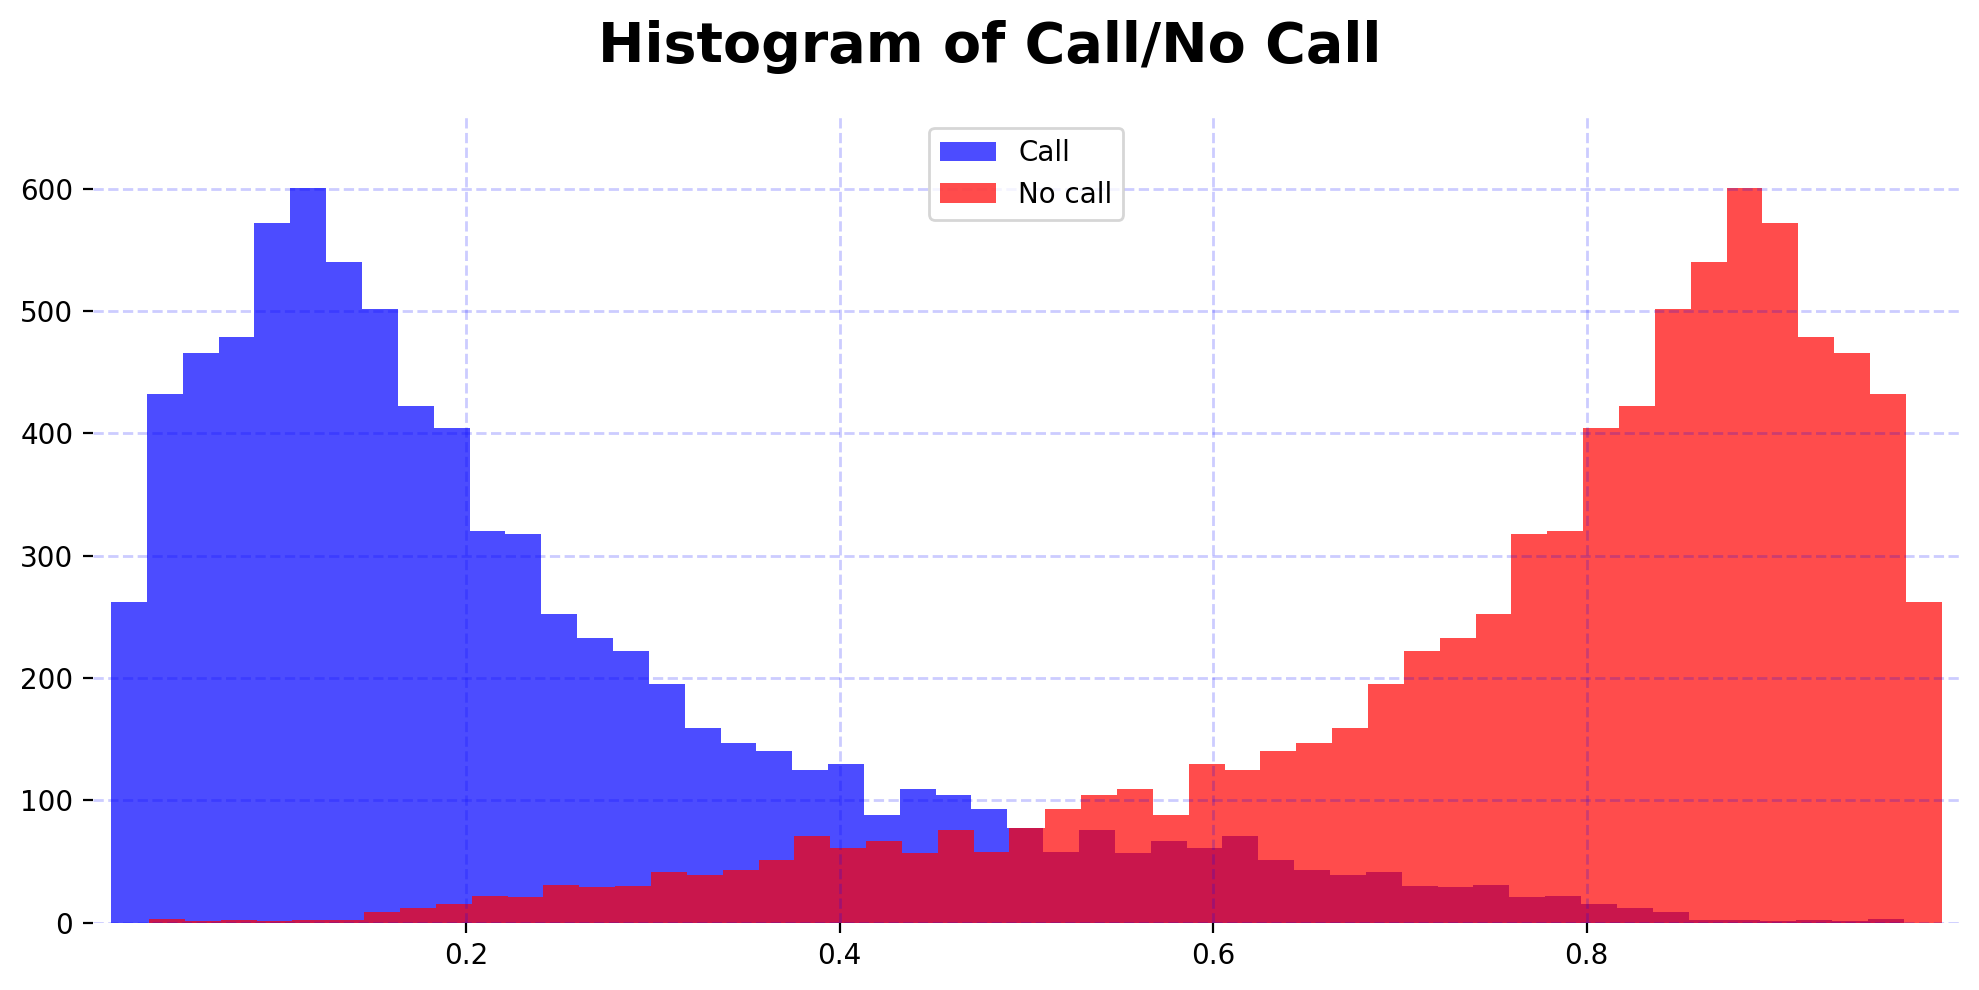

In [3]:
import matplotlib.pyplot as plt

# Get column names
cols = ["call", "no_call"]

# Init plot
fig, ax = plt.subplots(figsize=(10, 5), dpi=200)
ax.hist(rows_df["call"], bins=50, color="blue", label="Call", alpha=0.7, density=False)
ax.hist(
    rows_df["no_call"], bins=50, color="red", label="No call", alpha=0.7, density=False
)
plt.suptitle("Histogram of Call/No Call", size=20, weight="bold")
ax.margins(x=0.01, y=0.1)  # No margins on x and y-axis
ax.grid(color="blue", linestyle="--", linewidth=1, alpha=0.2)
for spine in ["top", "right", "bottom", "left"]:
    ax.spines[spine].set_visible(False)
fig.tight_layout()
ax.legend(loc="best")
fig.tight_layout()
plt.show()

In [4]:
call_sum = np.sum(rows_df["call"])
ncall_sum = np.sum(rows_df["no_call"])
total = call_sum + ncall_sum

# Sum
print(f"Call sum: {round(call_sum, 3)}")
print(f"No call sum: {round(ncall_sum, 3)}\n")

# Percentage
print(f"Call percentage: {round(call_sum/total, 3)}")
print(f"No call percentage: {round(ncall_sum/total, 3)}")

Call sum: 1847.086
No call sum: 6288.914

Call percentage: 0.227
No call percentage: 0.773


In [10]:
rows_df.describe()

,call,no_call
count,8136.000000,8136.000000
mean,0.227026,0.772974
std,0.175614,0.175614
min,0.009863,0.030206
25%,0.099348,0.694933
50%,0.172484,0.827516
75%,0.305067,0.900652
max,0.969794,0.990137


In [7]:
display(rows_df)

,row_id,emb,call,no_call
0,04029e3d-f38d-4732-a4f3-ed7d9a5ecce0_9,"[0.4765618, 0.46414986, 0.3187426, 1.00798, 0....",0.058981,0.941019
1,3206a89e-62ea-47d1-ac6c-bbf4d89baba9_9,"[1.0740846, 0.567787, 0.44531855, 0.44690418, ...",0.188369,0.811631
2,2969c474-14ea-43d3-a785-74812a1012d1_9,"[0.7935006, 0.6650428, 0.4069828, 0.2370947, 0...",0.015613,0.984387
3,1f26ba64-6697-4273-a378-c890e6d20720_9,"[1.0788813, 0.6915334, 0.3761121, 0.38029405, ...",0.011214,0.988786
4,2c514c7d-cdf9-4fb1-a6f3-1099d93442c2_3,"[0.40857872, 0.8114722, 0.60223275, 0.67038375...",0.117450,0.882550
...,...,...,...,...
8131,0aa759a9-df9e-4b00-a787-63198a25ead7_0,"[1.5357852, 1.1467174, 1.4343815, 0.50579125, ...",0.326181,0.673819
8132,331979ee-c814-466c-acb0-9b6b29fb1caf_6,"[0.75272655, 0.5986343, 0.83853036, 0.9410003,...",0.221359,0.778641
8133,1f6f86cf-8df2-4f22-a6d6-49417a05a0f3_3,"[1.448604, 1.3593525, 1.3178234, 0.34052515, 1...",0.378875,0.621125
8134,1b1baa46-4509-4881-ad7c-454d60a532c9_9,"[0.8958419, 0.42691746, 0.9814361, 0.82443017,...",0.080868,0.919132


In [12]:
import umap
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from sklearn.preprocessing import StandardScaler


def get_embedding_df(data: pd.DataFrame):
    # The "embedding" column contains 320 samples for each row
    emb_df = np.stack(data["emb"].values)
    scaled_data = StandardScaler().fit_transform(emb_df)

    # Get values for call and no_call
    df = pd.DataFrame()
    # df["species_num"] = data["species"].map({"call": 0, "no_call": 1})
    df["species_num"] = data.apply(lambda row: 0 if row["call"] > 0.5 else 1, axis=1)
    species = df["species_num"].values

    # Fit the UMAP model and transform the emb_df
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(emb_df)

    # Filter call/no_call
    embedding_call = embedding[species == 0]
    embedding_no_call = embedding[species == 1]

    return embedding_call, embedding_no_call

In [13]:
embedding_call, embedding_no_call = get_embedding_df(data=rows_df)

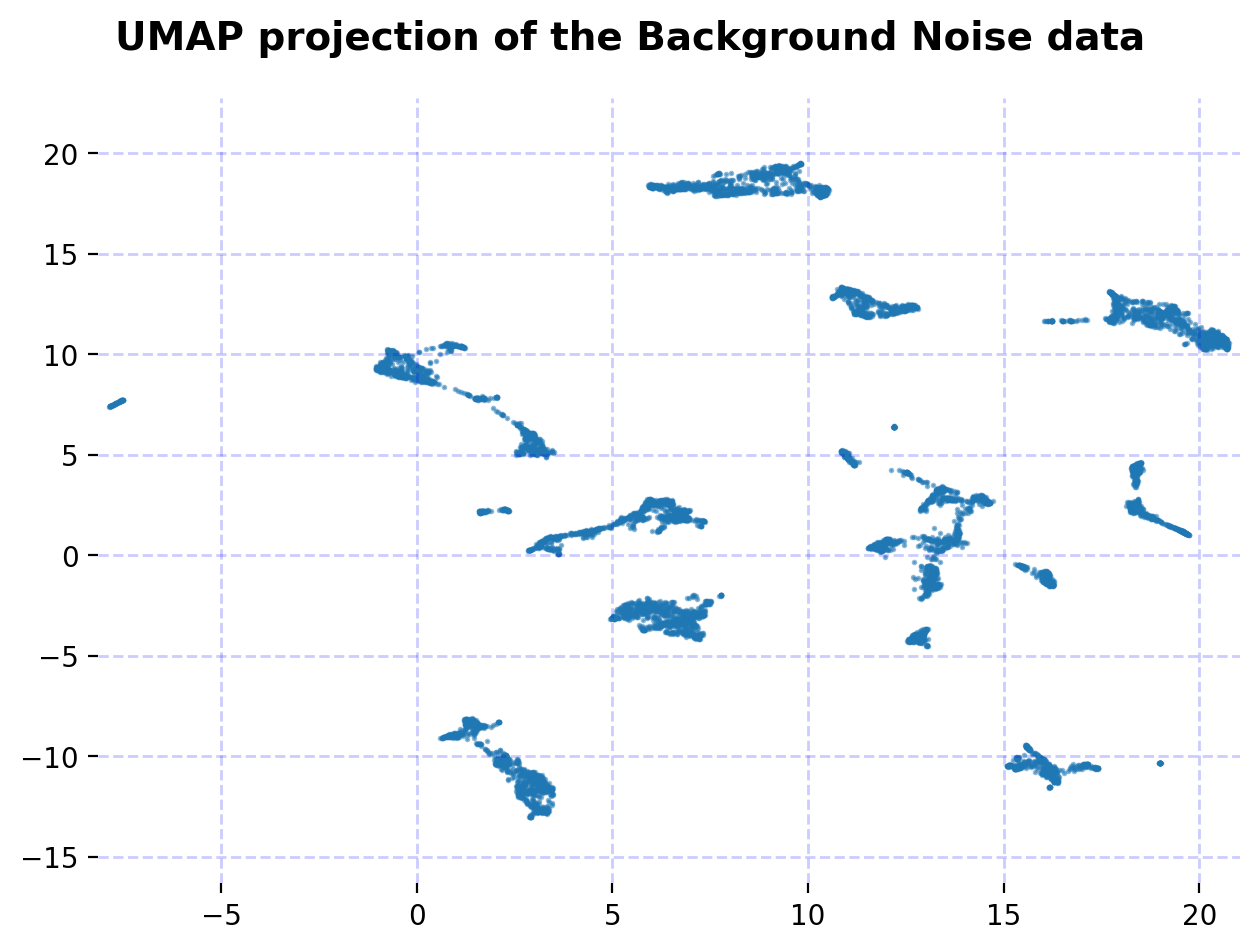

In [20]:
# The "emb" column contains 320 samples for each row
data = np.stack(rows_df["emb"].values)
scaled_data = StandardScaler().fit_transform(data)

# Fit the UMAP model and transform the data
reducer = umap.UMAP()
embedding = reducer.fit_transform(data)

# Plot the data
fig, ax = plt.subplots(figsize=(6.4, 4.8), dpi=200)
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5, s=1)
plt.suptitle("UMAP projection of the Background Noise data", fontsize=14, weight="bold")
ax.margins(x=0.01, y=0.1)  # No margins on x and y-axis
ax.grid(color="blue", linestyle="--", linewidth=1, alpha=0.2)
for spine in ["top", "right", "bottom", "left"]:
    ax.spines[spine].set_visible(False)
fig.tight_layout()
# ax.legend(loc="best")
fig.tight_layout()
plt.show()

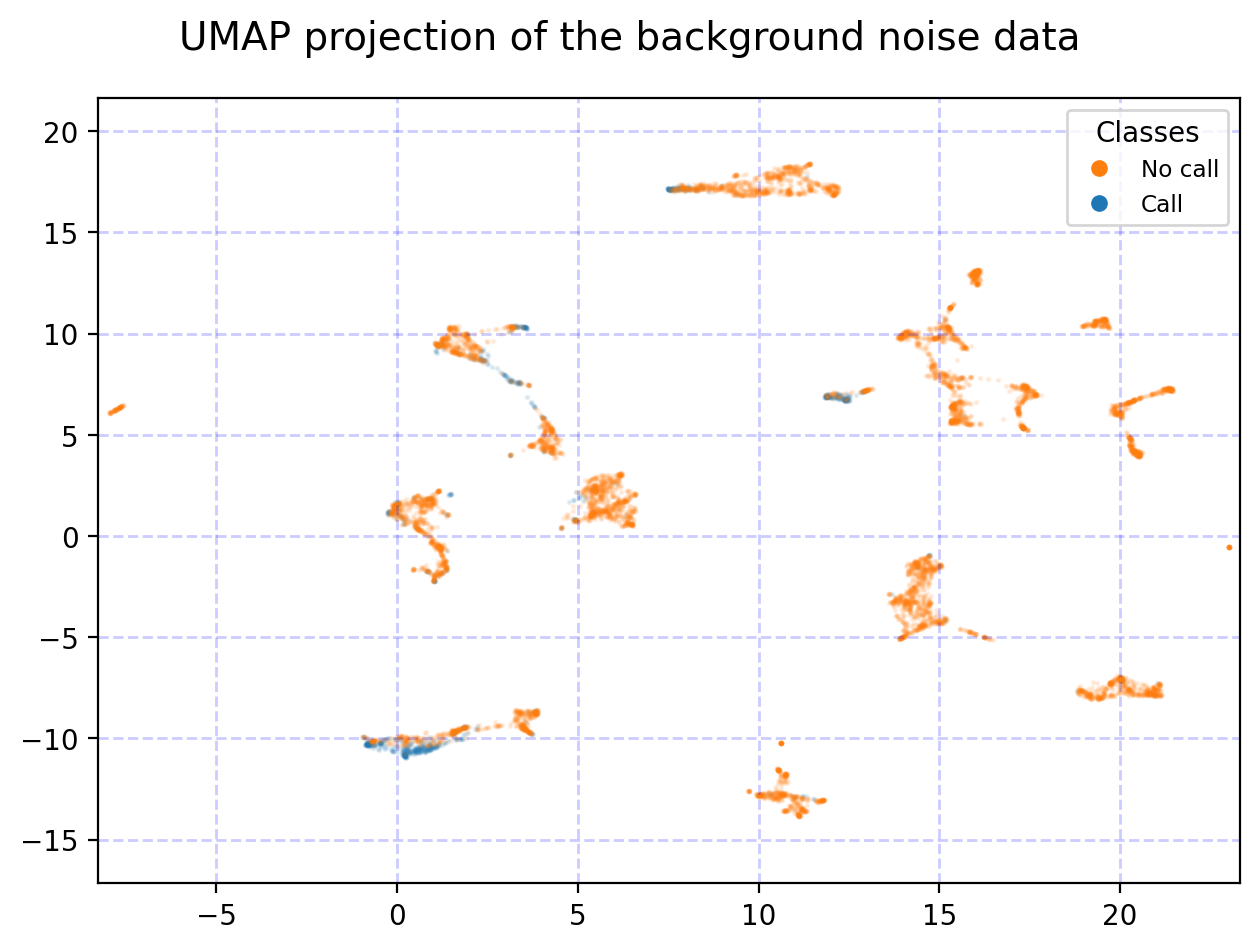

In [17]:
# Plot the data
fig, ax = plt.subplots(figsize=(6.4, 4.8), dpi=200)
fig.suptitle("UMAP projection of the background noise data", fontsize=14)
# Plot embeddings
ax.scatter(
    embedding_call[:, 0],
    embedding_call[:, 1],
    color="tab:blue",
    label="Call",
    alpha=0.1,
    s=1,
)
ax.scatter(
    embedding_no_call[:, 0],
    embedding_no_call[:, 1],
    color="tab:orange",
    label="No call",
    alpha=0.1,
    s=1,
)
ax.margins(x=0.01, y=0.1)  # No margins on x and y-axis
ax.grid(color="blue", linestyle="--", linewidth=1, alpha=0.2)
# Set custom legend
orange_marker = mlines.Line2D(
    [], [], color="tab:orange", marker="o", ls="None", markersize=5, label="No call"
)
blue_marker = mlines.Line2D(
    [],
    [],
    color="tab:blue",
    marker="o",
    ls="None",
    markersize=5,
    label="Call",
)
handles = [orange_marker, blue_marker]
legend = ax.legend(loc="best", title="Classes", fontsize="small", handles=handles)
# for spine in ["top", "right", "bottom", "left"]:
#     ax.spines[spine].set_visible(False)
fig.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


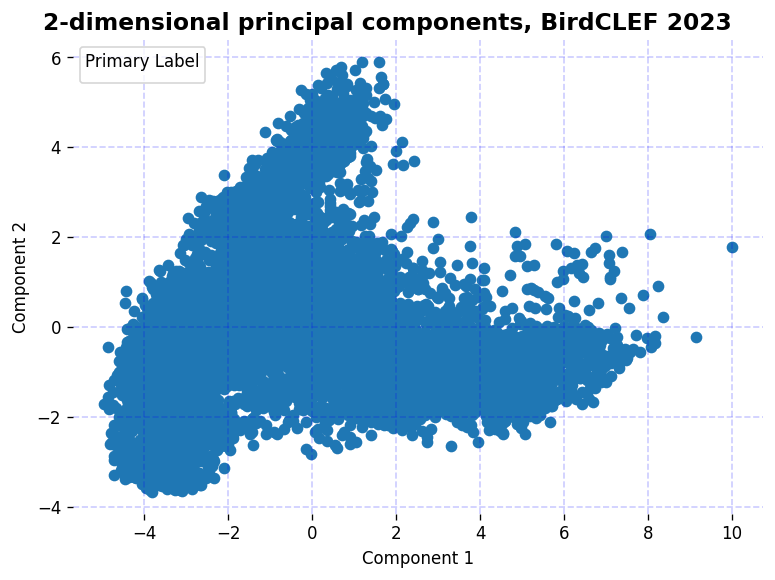

In [11]:
from sklearn.decomposition import PCA

X = np.stack(rows_df["emb"].values)
# primary_label = df.primary_label
# birdnet_label = df.birdnet_label

# PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)
pca_var = pca.explained_variance_ratio_
pca_curve = np.cumsum(pca_var)

# Create a new DataFrame with the PCA data and primary_label
pca_df = pd.DataFrame(X_pca, columns=["x", "y"])
# pca_df["primary_label"] = primary_label


# Plot 2-D PCA
def plot_pca_scatter(
    X_pca: np.array,
    # y_train: np.array,
    dataset_name="dataset",
    verbose=False,
):
    # Init figure
    fig, ax = plt.subplots(figsize=(6.4, 4.8), dpi=120)
    fig.suptitle(
        f"2-dimensional principal components, {dataset_name}",
        fontsize=14,
        weight="bold",
    )
    # primary_label = pca_df["primary_label"]
    # sns.scatterplot(data=pca_df, x="x", y="y", hue="primary_label")
    ax.scatter(pca_df["x"], pca_df["y"])
    ax.margins(x=0.05, y=0.05)  # margins on x and y axis
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.grid(color="blue", linestyle="--", linewidth=1, alpha=0.2)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles=handles,
        labels=labels,
        title="Primary Label",
        loc="upper left",
        fontsize="small",
    )
    spines = ["top", "right", "bottom", "left"]
    for s in spines:
        ax.spines[s].set_visible(False)
    fig.tight_layout(pad=0.5)
    plt.show()


# Plot the BirdNET embeddings
plot_pca_scatter(
    X_pca=pca_df,
    dataset_name="BirdCLEF 2023",
)